# Calculation of control fields for QFT gate on two qubits using the CRAB algorithm

Alexander Pitchford (agp1@aber.ac.uk)

In [3]:
import datetime

import matplotlib.pyplot as plt
import numpy as np

import qutip_qtrl.pulsegen as pulsegen
import qutip_qtrl.pulseoptim as cpo
from qutip import identity, sigmax, sigmay, sigmaz, tensor, about
from qutip_qip.algorithms import qft

example_name = "QFT"
%matplotlib inline


### Defining the physics

In [4]:
Sx = sigmax()
Sy = sigmay()
Sz = sigmaz()
Si = 0.5 * identity(2)

# Drift Hamiltonian
H_d = 0.5 * (tensor(Sx, Sx) + tensor(Sy, Sy) + tensor(Sz, Sz))
# The (four) control Hamiltonians
H_c = [tensor(Sx, Si), tensor(Sy, Si), tensor(Si, Sx), tensor(Si, Sy)]
n_ctrls = len(H_c)
# start point for the gate evolution
U_0 = identity(4)
# Target for the gate evolution - Quantum Fourier Transform gate
U_targ = qft(2)

### Defining the time evolution parameters

In [5]:
# Number of time slots
n_ts = 200
# Time allowed for the evolution
evo_time = 10

### Set the conditions which will cause the pulse optimisation to terminate

In [6]:
# Fidelity error target
fid_err_targ = 1e-3
# Maximum iterations for the optisation algorithm
max_iter = 20000
# Maximum (elapsed) time allowed in seconds
max_wall_time = 300

### Give an extension for output files

In [7]:
# Set to None to suppress output files
f_ext = "{}_n_ts{}.txt".format(example_name, n_ts)

### Create the optimiser objects

In [8]:
optim = cpo.create_pulse_optimizer(
    H_d,
    H_c,
    U_0,
    U_targ,
    n_ts,
    evo_time,
    fid_err_targ=fid_err_targ,
    max_iter=max_iter,
    max_wall_time=max_wall_time,
    alg="CRAB",
    dyn_type="UNIT",
    prop_type="DIAG",
    fid_type="UNIT",
    fid_params={"phase_option": "PSU"},
    gen_stats=True,
)

### Configure the pulses for each of the controls

In [9]:
dyn = optim.dynamics

# Control 1
crab_pgen = optim.pulse_generator[0]
# Start from a ramped pulse
guess_pgen = pulsegen.create_pulse_gen("LIN", dyn=dyn, pulse_params={"scaling": 3.0})
crab_pgen.guess_pulse = guess_pgen.gen_pulse()
crab_pgen.scaling = 0.0
# Add some higher frequency components
crab_pgen.num_coeffs = 5

# Control 2
crab_pgen = optim.pulse_generator[1]
# Apply a ramping pulse that will force the start and end to zero
ramp_pgen = pulsegen.create_pulse_gen(
    "GAUSSIAN_EDGE", dyn=dyn, pulse_params={"decay_time": evo_time / 50.0}
)
crab_pgen.ramping_pulse = ramp_pgen.gen_pulse()

# Control 3
crab_pgen = optim.pulse_generator[2]
# Add bounds
crab_pgen.scaling = 0.5
crab_pgen.lbound = -2.0
crab_pgen.ubound = 2.0


# Control 4
crab_pgen = optim.pulse_generator[3]
# Start from a triangular pulse with small signal
guess_pgen = pulsegen.PulseGenTriangle(dyn=dyn)
guess_pgen.num_waves = 1
guess_pgen.scaling = 2.0
guess_pgen.offset = 2.0
crab_pgen.guess_pulse = guess_pgen.gen_pulse()
crab_pgen.scaling = 0.1

init_amps = np.zeros([n_ts, n_ctrls])
for j in range(dyn.num_ctrls):
    pgen = optim.pulse_generator[j]
    pgen.init_pulse()
    init_amps[:, j] = pgen.gen_pulse()

dyn.initialize_controls(init_amps)

### Run the pulse optimisation

In [10]:
# Save initial amplitudes to a text file
if f_ext is not None:
    pulsefile = "ctrl_amps_initial_" + f_ext
    dyn.save_amps(pulsefile)
    print("Initial amplitudes output to file: " + pulsefile)

print("***********************************")
print("Starting pulse optimisation")
result = optim.run_optimization()

# Save final amplitudes to a text file
if f_ext is not None:
    pulsefile = "ctrl_amps_final_" + f_ext
    dyn.save_amps(pulsefile)
    print("Final amplitudes output to file: " + pulsefile)

Initial amplitudes output to file: ctrl_amps_initial_QFT_n_ts200.txt
***********************************
Starting pulse optimisation
Final amplitudes output to file: ctrl_amps_final_QFT_n_ts200.txt


### Report the results

In [11]:
result.stats.report()
print("Final evolution\n{}\n".format(result.evo_full_final))
print("********* Summary *****************")
print("Initial fidelity error {}".format(result.initial_fid_err))
print("Final fidelity error {}".format(result.fid_err))
print("Terminated due to {}".format(result.termination_reason))
print("Number of iterations {}".format(result.num_iter))
print(
    "Completed in {} HH:MM:SS.US".format(datetime.timedelta(seconds=result.wall_time))
)


------------------------------------
---- Control optimisation stats ----
**** Timings (HH:MM:SS.US) ****
Total wall time elapsed during optimisation: 0:05:00.006690
Wall time computing Hamiltonians: 0:00:21.529010 (7.18%)
Wall time computing propagators: 0:04:30.366652 (90.12%)
Wall time computing forward propagation: 0:00:02.221282 (0.74%)
Wall time computing onward propagation: 0:00:02.051295 (0.68%)
Wall time computing gradient: 0:00:00 (0.00%)

**** Iterations and function calls ****
Number of iterations: 6185
Number of fidelity function calls: 7406
Number of times fidelity is computed: 7406
Number of gradient function calls: 0
Number of times gradients are computed: 0
Number of times timeslot evolution is recomputed: 7406

**** Control amplitudes ****
Number of control amplitude updates: 7405
Mean number of updates per iteration: 1.1972514147130153
Number of timeslot values changed: 1480999
Mean number of timeslot changes per update: 199.99986495611074
Number of amplitude values

### Plot the initial and final amplitudes

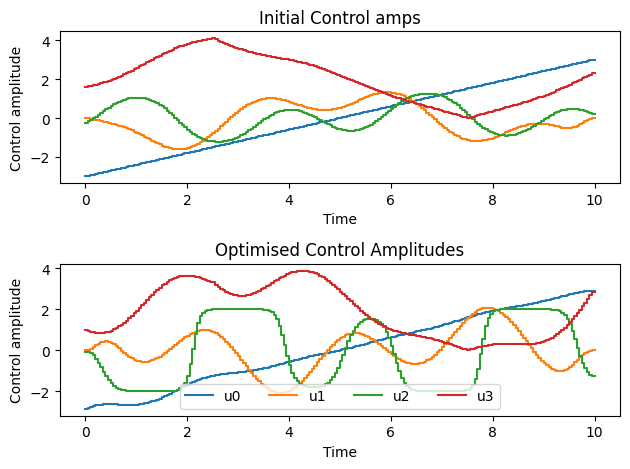

In [12]:
fig1 = plt.figure()
ax1 = fig1.add_subplot(2, 1, 1)
ax1.set_title("Initial Control amps")
ax1.set_xlabel("Time")
ax1.set_ylabel("Control amplitude")
for j in range(n_ctrls):
    ax1.step(
        result.time,
        np.hstack((result.initial_amps[:, j], result.initial_amps[-1, j])),
        where="post",
    )
ax2 = fig1.add_subplot(2, 1, 2)
ax2.set_title("Optimised Control Amplitudes")
ax2.set_xlabel("Time")
ax2.set_ylabel("Control amplitude")
for j in range(n_ctrls):
    ax2.step(
        result.time,
        np.hstack((result.final_amps[:, j], result.final_amps[-1, j])),
        where="post",
        label="u{}".format(j),
    )
ax2.legend(loc=8, ncol=n_ctrls)
plt.tight_layout()
plt.show()

### Versions

In [13]:
about()


QuTiP: Quantum Toolbox in Python
Copyright (c) QuTiP team 2011 and later.
Current admin team: Alexander Pitchford, Nathan Shammah, Shahnawaz Ahmed, Neill Lambert, Eric Giguère, Boxi Li, Simon Cross, Asier Galicia, Paul Menczel, and Patrick Hopf.
Board members: Daniel Burgarth, Robert Johansson, Anton F. Kockum, Franco Nori and Will Zeng.
Original developers: R. J. Johansson & P. D. Nation.
Previous lead developers: Chris Granade & A. Grimsmo.
Currently developed through wide collaboration. See https://github.com/qutip for details.

QuTiP Version:      5.1.1
Numpy Version:      1.26.4
Scipy Version:      1.13.0
Cython Version:     3.0.10
Matplotlib Version: 3.9.0
Python Version:     3.12.3
Number of CPUs:     8
BLAS Info:          Generic
INTEL MKL Ext:      /home/rochisha/miniconda3/envs/qutip-dev/lib/libmkl_rt.so.2
Platform Info:      Linux (x86_64)
Installation path:  /home/rochisha/miniconda3/envs/qutip-dev/lib/python3.12/site-packages/qutip

Installed QuTiP family packages
-------